<a href="https://colab.research.google.com/github/MEskerod/project_deeplearning_2023/blob/main/deeplearning_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Define the path to the zipped folder in your Google Drive
tar_file_path = '/content/drive/MyDrive/RNAStralign.tar.gz' #Change!

# Define the folder where you want to unzip the files (in-memory)
extracted_folder = '/content/sequences' #Change name?!

# Import files

In [4]:
import tarfile, os

# Create the destination folder (in-memory)
os.makedirs(extracted_folder, exist_ok=True)

# Extract the tar.gz archive
with tarfile.open(tar_file_path, 'r:gz') as tar:
    tar.extractall(extracted_folder)

# List the files in the extracted folder
os.listdir(extracted_folder)

['RNAStrAlign-master-aedbaf9e95ebad34d15752fe1b750f5ff3960bca']

In [5]:
import os
from fnmatch import fnmatch

root = extracted_folder
pattern = "*.ct"

ct_files = []
for path, subdirs, files in os.walk(root):
    for name in files:
        if fnmatch(name, pattern):
            ct_files.append(os.path.join(path, name))
with open("ct_files.txt", "w") as output:
    output.write("\n".join(ct_files))


### Picking files

In [ ]:
import random as rd

def singleFamily(family: str, txt_file="ct_files.txt") -> list:
    '''
    Returns list of files from a single specified family
    '''
    ct_files = []
    with open(txt_file, "r") as file:
        for line in file:
            if not line.startswith("#") and family in line:
                ct_files.append(line.strip())
    return ct_files

def leaveOneFamilyOut(family: str, txt_file="ct_files.txt"):
    '''
    Returns list of files from all families except the specified family
    '''
    ct_files = []
    with open(txt_file, "r") as file:
        for line in file:
            if not line.startswith("#") and family not in line:
                ct_files.append(line.strip())
    return ct_files

def pickFromFamilies(data_size, txt_file="ct_files.txt"):
    '''
    Returns a list of files with data_size from EACH family.
    If a family does not have enough data, all data from that family is added.
    '''
    ct_files = []
    with open(txt_file, "r") as file: #Read paths to ct_files
        for line in file:
            if not line.startswith("#"):
                ct_files.append(line.strip())

    families = []
    for file in ct_files: #Find all family names
        families.append(file.split("\\")[2])
    families = list(set(families)) #Remove duplicates

    data = [] #Create list of lists, where each list contains all files from a family
    for family in families:
        data.append([line for line in ct_files if family in line])

    ct_files = []
    for family in data: #Pick data_size files from each family
        try:
            ct_files.append(rd.sample(family, data_size))
        except:
            print("Not enough data in family: ", family[0].split("\\")[2], " for size: ", data_size, ".\n Missing", data_size-len(family),"files.","\n Adding all data from family.")

    return ct_files


# Set up preprocessing of RNA files   

Below are the functions that is needed for processing the files from .ct files to images

In [6]:
def read_bpseq(file: str) -> tuple():
    """
    Takes a .bpseq file and returns the sequence as a string and a list of base pairs
    """

    sequence = ""
    pairs = []

    with open(file, 'r') as f:
        lines = [line.split() for line in f.readlines()]

    #Remove header - if any
    header_lines = 0
    for line in lines:
        if line[0] == '1':
                break
        else:
            header_lines += 1

    lines = lines[header_lines:]

    #Make sequence in bp list
    for line in lines:
        sequence += line[1]
        if line[2] != '0':
            pairs.append((int(line[0])-1, int(line[2])-1)) #The files start indexing from 1
    return sequence, pairs

def read_ct(file: str) -> tuple():
    """
    Takes a .ct file and returns the sequence as a string and a list of base pairs
    """
    sequence = ""
    pairs = []

    with open(file, 'r') as f:
        lines = [line.split() for line in f.readlines()]

    #Remove header - if any
    header_lines = 0
    for line in lines:
        if line[0] == '1':
                break
        else:
            header_lines += 1

    lines = lines[header_lines:]

    for line in lines:
        sequence += line[1]
        if line[4] != '0':
            pairs.append((int(line[0])-1, int(line[4])-1)) #The files start indexing from 1

    return sequence, pairs

In [7]:
import numpy as np

def make_matrix_from_sequence(sequence: str) -> np.array:
    """
    A sequence is converted to a matrix containing all the possible base pairs

    If the bases does not form  valid pair the cell is white.
    The valid base pairs has the following colors:
    GC = green
    CG = dark green
    UG = blue
    GU = dark blue
    UA = red
    AU = dark red
    """
    colors = {"invalid_pairing": [255, 255, 255],
              "unpaired": [64, 64, 64],
              "GC": [0, 255, 0],
              "CG": [0, 128, 0],
              "UG": [0, 0, 255],
              "GU": [0, 0, 128],
              "UA": [255, 0, 0],
              "AU": [128, 0, 0]}
    basepairs = ["GC", "CG", "UG", "GU", "UA", "AU"]

    N = len(sequence)

    matrix = np.full((N,N,3),255, dtype="uint8")

    for i in range(N):
        for j in range(N):
            pair = sequence[i] + sequence[j]
            if i == j:
                matrix[i, j, :] = colors["unpaired"]
            elif pair in basepairs:
                matrix[i, j, :] = colors[pair]

    if N%2==0:
      row = np.full((1, N, 3), 0, dtype="uint8")
      column = np.full((N+1, 1, 3), 0, dtype="uint8")
      matrix = np.append(matrix, row, axis = 0)
      matrix = np.append(matrix, column, axis = 1)

    return matrix


def make_matrix_from_basepairs(sequence: str, pairs: list) -> np.array:
    """
    Takes a list of all the base pairs.
    From the list a matrix is made, with each cell coresponding to a base pair colered black
    """
    black = [0, 0, 0]

    N = len(sequence)
    matrix = np.full((N,N,3),255, dtype="uint8")

    for pair in pairs:
        matrix[pair[0], pair[1], :] = black

    if N%2==0:
      row = np.full((1, N, 3), 0, dtype="uint8")
      column = np.full((N+1, 1, 3), 0, dtype="uint8")
      matrix = np.append(matrix, row, axis = 0)
      matrix = np.append(matrix, column, axis = 1)

    return matrix

In [8]:
import matplotlib.pyplot as plt

def save_matrix(matrix: np.array, name: str) -> None:
    """
    Saves the matrix as a .png file
    """
    plt.imsave(name, matrix)

# Convert sequences
The sequences needs to be read from the .ct files and converted into images that can be used as input to the CNN.    

In [9]:
import os

def getCtFromTxt(txt_file):
    """
    Takes a txt file containing the path to all the ct files and returns a list of the paths
    """
    with open(txt_file, 'r') as f:
        ct_files = f.readlines()
    ct_files = [file.strip() for file in ct_files if file.strip()[0] != "#"]
    return ct_files

def save_to_matrices(file_list, input_matrix_path, output_matrix_path):
    """
    For every file supplied in file_list:
      a matrix of all possible base pairs is saved to input_matrix_path
      a matrix showing the base pairs in the actual sequence is saved to output_matrix_path
    """
    for file_name in file_list:
        sequence, pairs = read_ct(file_name)
        input_matrix = make_matrix_from_sequence(sequence)
        save_matrix(input_matrix, os.path.join(input_matrix_path, os.path.splitext(os.path.basename(file_name))[0] + '.png'))
        output_matrix = make_matrix_from_basepairs(sequence, pairs)
        save_matrix(output_matrix, os.path.join(output_matrix_path, os.path.splitext(os.path.basename(file_name))[0] + '.png'))

In [10]:
#TODO - Change to different file list! This is just for testing.

ct_files = getCtFromTxt("ct_files.txt")

file_list = []

for file_name in ct_files:
    if "tRNA_database" in file_name:
        file_list.append(file_name)

len(file_list)

9245

In [11]:
input_matrix_path = "input"
output_matrix_path = "result"

# Create folders for images
os.makedirs(input_matrix_path, exist_ok=True)
os.makedirs(output_matrix_path, exist_ok=True)

save_to_matrices(file_list, input_matrix_path, output_matrix_path)


# Set up data for network

### Splitting data into train and validation sets

In [12]:
def move_files(src_dir, dst_dir, file_list):
    for filename in file_list:
        src_path = os.path.join(src_dir, filename)
        dst_path = os.path.join(dst_dir, filename)
        os.rename(src_path, dst_path)

In [13]:
import os

#Make directories
directories = ['train', 'validation']
subdirectories = ['input_images', 'output_images']

for directory in directories:
    os.makedirs(directory, exist_ok=True)
    for subdirectory in subdirectories:
        dir_path = os.path.join(directory, subdirectory)
        os.makedirs(dir_path, exist_ok=True)

In [14]:
from sklearn.model_selection import train_test_split

#List input and outputs
input_images = os.listdir(input_matrix_path)
output_images = os.listdir(output_matrix_path)

#Make split
input_train, input_valid, output_train, output_valid = train_test_split(input_images, output_images, train_size=0.8, random_state=42, shuffle=True) #NOTE - Change to the fraction we want nd whether we want shuffle or not


#Move files to train and validation folders
train_input_dir = 'train/input_images'
train_output_dir = 'train/output_images'
val_input_dir = 'validation/input_images'
val_output_dir = 'validation/output_images'

move_files(input_matrix_path, train_input_dir, input_train)
move_files(output_matrix_path, train_output_dir, output_train)
move_files(input_matrix_path, val_input_dir, input_valid)
move_files(output_matrix_path, val_output_dir, output_valid)

### Read data and set up data loader

In [15]:
import os
from torch.utils.data import Dataset
from torchvision import transforms

class ImageToImageDataset(Dataset):
    """

    """
    def __init__(self, input_dir, output_dir, transform = None):
        self.input_dir = input_dir
        self.output_dir = output_dir
        self.input_files = os.listdir(input_dir)
        self.output_files = os.listdir(output_dir)
        self.transform = transform

    def __len__(self):
        return len(self.input_files)

    def __getitem__(self, idx):
        input_image =  plt.imread(os.path.join(self.input_dir, self.input_files[idx]))
        output_image = plt.imread(os.path.join(self.output_dir, self.output_files[idx]))

        if self.transform:
            input_image = self.transform(input_image)
            output_image = self.transform(output_image)

        return input_image, output_image

dataTransformer = transforms.Compose([
    transforms.ToTensor(), #Convert image to tensor
])


In [16]:
from torch.utils.data import DataLoader

train_dataset = ImageToImageDataset(train_input_dir, train_output_dir, dataTransformer)
validation_dataset = ImageToImageDataset(val_input_dir, val_output_dir, dataTransformer)

batch_size = 1 #NOTE - Change?!

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) #Do shuffle need to be true???
val_loader = DataLoader(validation_dataset, batch_size=batch_size)

# Model

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class RNASecondaryStructureCAE(nn.Module):
    def __init__(self, num_hidden_channels, num_channels=4):
        """
        args:
        num_channels: length of the one-hot encoding vector
        num_hidden_channels: number of channels in the hidden layers of both encoder and decoder
        """
        super(RNASecondaryStructureCAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(
                in_channels=num_channels,
                out_channels=num_hidden_channels,
                kernel_size=3,
                padding=1,
            ),
            nn.BatchNorm2d(num_hidden_channels),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=num_hidden_channels,
                out_channels=num_hidden_channels * 2,
                kernel_size=3,
                padding=1,
                # Maybe use dilation in deeper layers?
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # Doesn't make sense for our data?
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=num_hidden_channels * 2,
                out_channels=num_hidden_channels,
                kernel_size=3,
                stride=2,
            ),
            nn.ReLU(),
            nn.ConvTranspose2d(
                in_channels=num_hidden_channels,
                out_channels=num_channels,
                kernel_size=3,
                padding=1,
            ),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Function for training the model

### Loss functions

In [ ]:
def BCE(predicted, observed):
  return nn.BCELoss(predicted, observed)

def DICE(predicted, observed):
  return

### Optimizers

In [ ]:
def adam_optimizer(model, lr):
  return torch.optim.Adam(model.parameters(), lr=lr)

### Plots for training

In [59]:
import matplotlib.pyplot as plt
def show_matrices(inputs, observed, predicted):

  fig, axs = plt.subplots(1, 3, figsize=(6,2))

  axs[0].imshow(inputs.permute(0, 2, 3, 1).squeeze().detach().cpu().numpy())
  axs[0].set_title("Input")

  axs[1].imshow(observed.permute(0, 2, 3, 1).squeeze().detach().cpu().numpy())
  axs[1].set_title("Observed")

  axs[2].imshow(predicted.permute(0, 2, 3, 1).squeeze().detach().cpu().numpy())
  axs[2].set_title("Predicted")

  plt.tight_layout()
  plt.show()


  def show_loss():
    return


### Funcition for training

In [70]:

def fit_model(model, train_dataset, validation_dataset, optimizer = adam_optimizer, lr=0.01, bs=1, epochs=5):
  train_dl = DataLoader(train_dataset, batch_size=bs)
  valid_dl = DataLoader(validation_dataset, batch_size=bs)

  opt = optimizer(model, lr)

  #Add stuff to track history
  train_loss_history = []
  valid_loss_history = []
  plot_time_train = []
  plot_time_valid = []

  t = 1 #To keep track of time

  #See stats before starting

  for epoch in range(epochs):
    running_loss = 0.0
    model.train()

    for input, output in train_dl:
      #Forward pass
      predicted = model(input.cuda())

      #Compute loss
      loss = loss_func(predicted, output.cuda())
      train_loss_history.append(loss.detach().cpu().numpy())
      plot_time_train.append(t)
      t += 1 #Maybe wait to validation?

      # Backpropagation, optimization and zeroing the gradients
      loss.backward()
      opt.step()
      opt.zero_grad()

      running_loss += loss.item()

    show_matrices(input, output, predicted)


    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {round(running_loss / len(train_dl),4)}")

  #Loss plot
  plt.figure()
  plt.plot(plot_time_train, train_loss_history, label = "Training")
  plt.title("Loss")
  plt.legend()
  plt.show()


# Training models

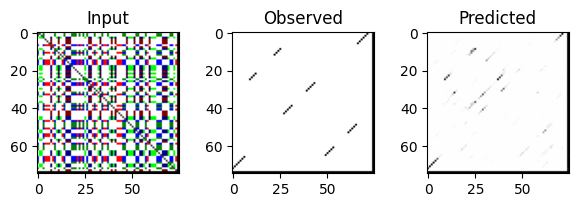

Epoch [1/5], Loss: 0.0143


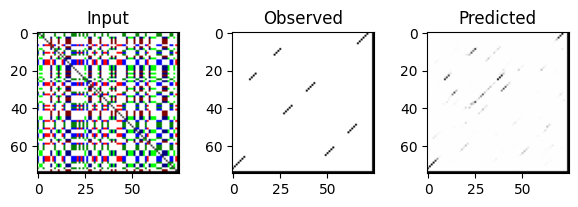

Epoch [2/5], Loss: 0.0102


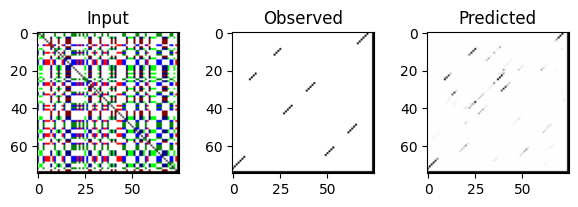

Epoch [3/5], Loss: 0.0098


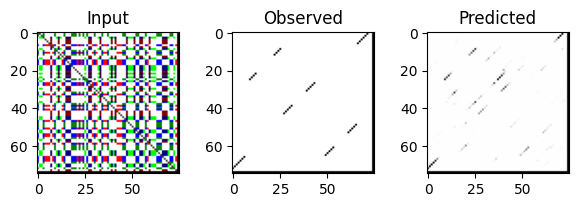

Epoch [4/5], Loss: 0.0095


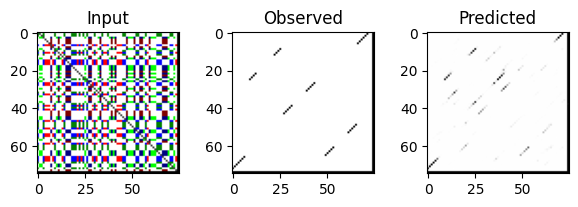

Epoch [5/5], Loss: 0.0094


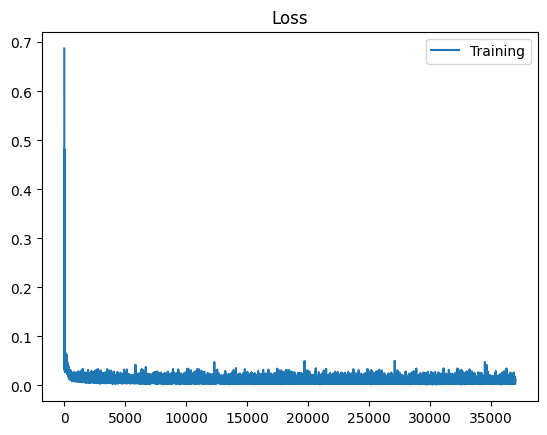

Training finished


In [71]:
%matplotlib inline
import torch.nn.functional as F

num_input_channels = 8
cae = RNASecondaryStructureCAE(num_input_channels).cuda()
loss_func = F.binary_cross_entropy

fit_model(cae, train_dataset, validation_dataset)

print("Training finished")